# Power ADC Measurement Map

## Freq Sweep Program

In [15]:
import numpy as np
import matplotlib.pyplot as plt

from qick import *
from qick.averager_program import QickSweep, merge_sweeps
from qick.asm_v1 import QickRegister
from qick.pyro import make_proxy

RegisterType = ["freq", "time", "phase", "adc_freq"]

MHz = 1
class FreqSweepExample(RAveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        cfg = self.cfg
        freq_rf     = cfg["start"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = int(cfg["pulse_time"] * 3/4) - 10,    # Readout length
                                                            # 10 is subtracted to
                                                            # make margin in timing
        )
        (self.ro_rp, self.ro_freq) = self._ro_regmap[0, "freq"]
        (self.gen_rp, self.gen_freq) = self._gen_regmap[0, "freq"]
        # Convert RF frequency to DAC DDS register value
        self.freq_dac = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )
        # Convert RF frequency to ADC DDS register value
        self.freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )
        # Make endless pulse
        self.set_pulse_registers(
            ch      = 0,            # Generator channel
            style   = "const",      # Output is envelope * gain * DDS output
            freq    = self.freq_dac, # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = cfg["gain"],  # Generator amplitude
            phrst   = 0,            # Generator DDS phase reset
            length  = 100,          # Dummy length
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = self.freq_adc, # Readout DDS frequency
            length  = 1600,       # Dummy length
            phrst   = 0,        # Readout DDS phase reset
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.synci(100000)

    def body(self):
        cfg = self.cfg
        # Put the generator's frequency register to temporary register (page : 0, register : 6)
        self.mathi(self.gen_rp, 6, self.gen_freq, '+', 0)
        self.mathi(self.ro_rp, 6, self.ro_freq, '+', 0)
        # Make endless pulse
        self.set_pulse_registers(
            ch      = 0,            # Generator channel
            style   = "const",      # Output is envelope * gain * DDS output
            freq    = self.freq_dac,    # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = cfg["gain"],  # Generator amplitude
            phrst   = 0,            # Generator DDS phase reset
            length  = 100,          # Dummy length
            mode    = "periodic",   # Set pulse mode to periodic
        )
        # Set demodulator DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = self.freq_adc, # Readout DDS frequency
            length  = 1600,       # Dummy length
            phrst   = 0,        # Readout DDS phase reset
        )
        self.mathi(self.gen_rp, self.gen_freq, 6, '+', 0)
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 100
        )
        
        self.mathi(self.ro_rp, self.ro_freq, 6, '+', 0)
        self.readout(
            ch      = 0,        # Readout channel
            t       = 100       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        # Make measurement triggers and shift t_sync
        for i in range(cfg["number_of_pulse"]):
            self.sync_all()
            self.trigger(
                adcs    = [0],      # Readout channels
                adc_trig_offset = 150 # Readout will capture the data @ sync_t + 50
            )

        self.sync_all(100)
        
        self.set_pulse_registers(
            ch      = 0,            # Generator channel
            style   = "const",      # Output is envelope * gain * DDS output
            freq    = self.freq_dac,    # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = 0,  # Generator amplitude
            phrst   = 0,            # Generator DDS phase reset
            length  = 100,          # Dummy length
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.mathi(self.gen_rp, self.gen_freq, 6, '+', 0)
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 100
        )
        self.sync_all(1000)
        # Make sure that do not read buffer before experiment ends
        self.wait_all()
    
    def update(self): 
        # Update readout frequency register 
        self.mathi(
            self.ro_rp, self.ro_freq, self.ro_freq, '+',
            self.freq2reg_adc(self.cfg["step"], 0, 0)
        )
        # Update generator frequency register
        self.mathi(
            self.gen_rp, self.gen_freq, self.gen_freq, '+',
            self.freq2reg(self.cfg["step"], 0, 0)
        )
        self.synci(10)

## Get SoC Instance

In [16]:
# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")

Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_eda6ff1d27b14fc8a129db5e25e0e367@192.168.2.99:34677


## Set Up Filter and Attenuator

In [17]:
dac_att1 = 31
dac_att2 = 31
# Set DAC Channel 0 attenuation 31 dB and 31 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,dac_att1,dac_att2)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

adc_att = 31
# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,adc_att)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

## Set Up Program

In [18]:
dac_gain = 1084

cfg = {
    # Experiment Setup
    "reps" : 1,
    "expts" : 60,
    "start" : 200,
    "step" : 10,
    "gain" : dac_gain,
    # Parameter Setup
    "pulse_time" : 65000,
    "number_of_pulse" : 500,
}
prog = FreqSweepExample(
    soccfg,
    cfg
)
print(prog)


// Program

        regwi 0, $22, 178956971;                //freq = 178956971
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 1084;                     //gain = 1084
        regwi 0, $26, 852068;                   //phrst| stdysel | mode | | outsel = 0b01101 | length = 100 
        regwi 4, $22, 357913942;                //freq = 357913942
        regwi 4, $26, 263744;                   //mode | outsel = 0b00100 | length = 1600 
        synci 100000;
        regwi 0, $13, 0;
        regwi 0, $14, 59;
LOOP_I: regwi 0, $15, 0;
LOOP_J: mathi 0, $6, $22 + 0;
        mathi 4, $6, $22 + 0;
        regwi 0, $22, 178956971;                //freq = 178956971
        regwi 0, $23, 0;                        //phase = 0
        regwi 0, $25, 1084;                     //gain = 1084
        regwi 0, $26, 852068;                   //phrst| stdysel | mode | | outsel = 0b01101 | length = 100 
        regwi 4, $22, 357913942;                //freq = 357913942
        

## Run Program

In [19]:
expts, avgi, avgq  = prog.acquire(soc = soc, progress = True, start_src = "internal")
avgi = np.array(avgi[0]).mean(axis = 0)
avgq = np.array(avgq[0]).mean(axis = 0)

meas_power = 10 * np.log10(avgi * avgi + avgq * avgq)
meas_phase = np.angle(avgi + 1j * avgq)

  0%|          | 0/60 [00:00<?, ?it/s]

## Plot Results

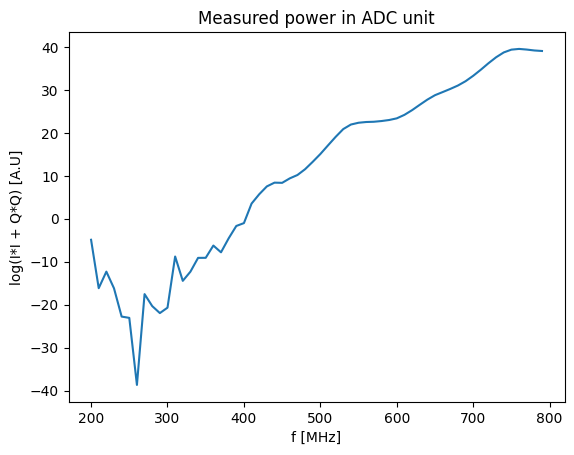

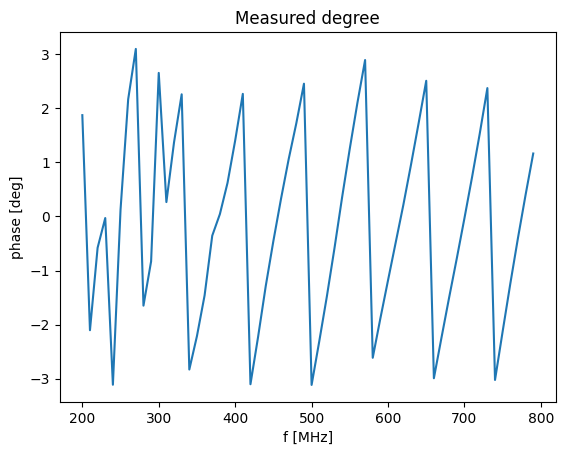

In [20]:
plt.figure()
plt.plot(expts, meas_power)
plt.xlabel("f [MHz]")
plt.ylabel("log(I*I + Q*Q) [A.U]")
plt.title("Measured power in ADC unit")
plt.show()

plt.plot(expts, meas_phase)
plt.xlabel("f [MHz]")
plt.ylabel("phase [deg]")
plt.title("Measured degree")
plt.show()

## Output Power Map

In [39]:
import json

power = {}
power_plot = []
with open("./PowerGainMap/pwr_map_200.0MHz_800.0MHz.json", "r", encoding="utf8") as f:
    data = json.load(f)
    for freq in expts:
        power[freq] = data[str(float(freq))][str(dac_gain)] - dac_att1 - dac_att2
        power_plot.append(power[freq])

plt.plot(expts, power_plot)
plt.title("Actual Power Input at QICK")
plt.xlabel("f [MHz]")
plt.ylabel("P [dBm]")
plt.show()

Traceback (most recent call last):
  File "c:\Users\Measurement6\anaconda3\envs\qcodes\Lib\site-packages\IPython\core\interactiveshell.py", line 3667, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Measurement6\AppData\Local\Temp\ipykernel_16968\3952463865.py", line 5, in <module>
    with open("./PowerGainMap/pwr_map_200.0MHz_800.0MHz.json", "r", encoding="utf8") as f:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Measurement6\anaconda3\envs\qcodes\Lib\site-packages\IPython\core\interactiveshell.py", line 326, in _modified_open
    return io_open(file, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: './PowerGainMap/pwr_map_200.0MHz_800.0MHz.json'


## Caculate Calibration

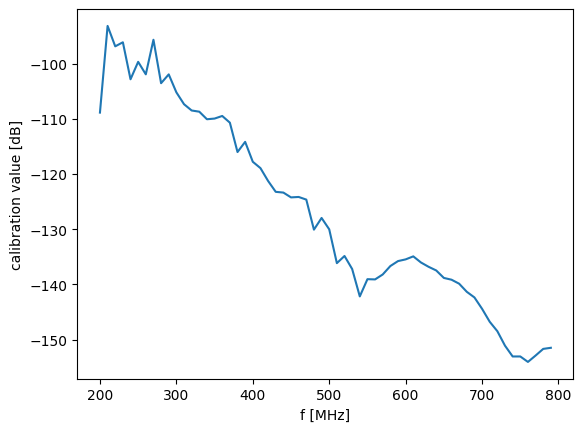

In [ ]:
import h5py
from datetime import datetime

power_calibration = []

for id, freq in enumerate(expts):
    power_calibration.append(power[freq]- meas_power[id] - adc_att)

plt.plot(expts, power_calibration)
plt.xlabel("f [MHz]")
plt.ylabel("calibration value [dB]")
plt.show()

naive_dt = datetime.now()
_date = naive_dt.strftime("%Y-%m-%d_%H_%M_%S")
with h5py.File(f"./ADC_Pwr_Map_{_date}.h5", "w") as f:
    # Store other data types as datasets
    f.create_dataset("Frequency",data = expts)
    f.create_dataset("Calibration",data = power_calibration)

## Calibrate Result

  0%|          | 0/60 [00:00<?, ?it/s]

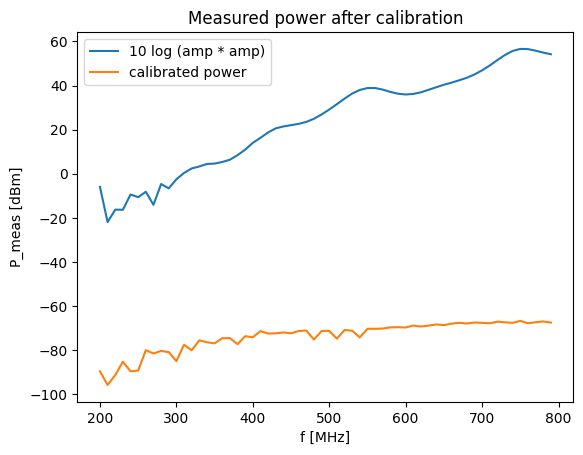

In [ ]:
adc_att = 21
# Set ADC Channel attenuation 20 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,adc_att)

dac_gain = 3000

cfg = {
    # Experiment Setup
    "reps" : 1,
    "expts" : 60,
    "start" : 200,
    "step" : 10,
    "gain" : dac_gain,
    # Parameter Setup
    "pulse_time" : 65000,
    "number_of_pulse" : 500,
}
prog = FreqSweepExample(
    soccfg,
    cfg
)

expts, avgi, avgq  = prog.acquire(soc = soc, progress = True, start_src = "internal")
avgi = np.array(avgi[0]).mean(axis = 0)
avgq = np.array(avgq[0]).mean(axis = 0)

meas_power = 10 * np.log10(avgi * avgi + avgq * avgq)
meas_phase = np.angle(avgi + 1j * avgq)

calb_power = meas_power + power_calibration + adc_att

plt.plot(expts, meas_power, label = "10 log (amp * amp)")
plt.plot(expts, calb_power, label = "calibrated power")
plt.legend()
plt.title("Measured power after calibration")
plt.ylabel("P_meas [dBm]")
plt.xlabel("f [MHz]")
plt.show()